# Catboost predictor

In [1]:
# import basic libraries
import pandas as pd

# import machine learning libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#import catboost
from catboost import CatBoostRegressor

In [2]:
#import the data
X_train = pd.read_csv("data/generated/X_train.csv")
y_train = pd.read_csv("data/generated/y_train.csv")
X_test = pd.read_csv("data/generated/X_test.csv")
y_test = pd.read_csv("data/generated/y_test.csv")

In [3]:
X_test.head(50)

,Unnamed: 0,case:concept:name,time:timestamp,case:RequestedAmount,event_index_in_trace,Action_Created,Action_Deleted,Action_Obtained,Action_Released,Action_statechange,...,case:LoanGoal_Debt restructuring,case:LoanGoal_Existing loan takeover,case:LoanGoal_Extra spending limit,case:LoanGoal_Home improvement,case:LoanGoal_Motorcycle,case:LoanGoal_Not speficied,"case:LoanGoal_Other, see explanation",case:LoanGoal_Remaining debt home,case:LoanGoal_Tax payments,case:LoanGoal_Unknown
0,1080782,Application_796205430,2016-11-22 09:22:17.274000+00:00,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1080783,Application_796205430,2016-11-22 09:22:17.285000+00:00,0.0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,1080784,Application_796205430,2016-11-22 09:22:17.288000+00:00,0.0,2,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
3,1080785,Application_796205430,2016-11-22 09:22:17.291000+00:00,0.0,3,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,4
4,1080786,Application_796205430,2016-11-22 09:24:43.370000+00:00,0.0,4,2,0,1,0,2,...,0,0,0,0,0,0,0,0,0,5
5,1080787,Application_796205430,2016-11-22 09:25:50.242000+00:00,0.0,5,3,0,1,0,2,...,0,0,0,0,0,0,0,0,0,6
6,1080788,Application_796205430,2016-11-22 09:25:50.921000+00:00,0.0,6,3,0,1,0,3,...,0,0,0,0,0,0,0,0,0,7
7,1080789,Application_796205430,2016-11-22 09:26:06.138000+00:00,0.0,7,3,0,1,0,4,...,0,0,0,0,0,0,0,0,0,8
8,1080790,Application_796205430,2016-11-22 09:26:06.151000+00:00,0.0,8,3,1,1,0,4,...,0,0,0,0,0,0,0,0,0,9
9,1080791,Application_796205430,2016-11-22 09:26:06.160000+00:00,0.0,9,4,1,1,0,4,...,0,0,0,0,0,0,0,0,0,10


In [4]:
y_test = y_test['remaining_time']
y_train = y_train['remaining_time']

### Pre-process the data

In [5]:
# Convert timestamp to a pandas datetime object
X_train['timestamp'] = pd.to_datetime(X_train['time:timestamp'],format='ISO8601')

# Extract relevant features
X_train['year'] = X_train['timestamp'].dt.year
X_train['month'] = X_train['timestamp'].dt.month
X_train['day'] = X_train['timestamp'].dt.day
X_train['hour'] = X_train['timestamp'].dt.hour
X_train['minute'] = X_train['timestamp'].dt.minute
X_train['second'] = X_train['timestamp'].dt.second
X_train['microsecond'] = X_train['timestamp'].dt.microsecond 

# Drop the original timestamp column
X_train = X_train.drop(['time:timestamp', 'timestamp'], axis=1)

In [6]:
# Convert timestamp to a pandas datetime object
X_test['timestamp'] = pd.to_datetime(X_test['time:timestamp'],format='ISO8601')

# Extract relevant features
X_test['year'] = X_test['timestamp'].dt.year
X_test['month'] = X_test['timestamp'].dt.month
X_test['day'] = X_test['timestamp'].dt.day
X_test['hour'] = X_test['timestamp'].dt.hour
X_test['minute'] = X_test['timestamp'].dt.minute
X_test['second'] = X_test['timestamp'].dt.second
X_test['microsecond'] = X_test['timestamp'].dt.microsecond 

# Drop the original timestamp column
X_test = X_test.drop(['time:timestamp', 'timestamp'], axis=1)

In [7]:
# Drop the unnamed column
X_test = X_test.drop(['Unnamed: 0'], axis=1)
X_train = X_train.drop(['Unnamed: 0'], axis=1)

In [8]:
# Separate categorical and numeric features
categorical_features = ['case:concept:name']
numeric_features = X_train.columns.difference(categorical_features)

# Convert categorical features to string
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

In [13]:
X_train.dtypes

case:concept:name                           object
case:RequestedAmount                       float64
event_index_in_trace                         int64
Action_Created                               int64
Action_Deleted                               int64
Action_Obtained                              int64
Action_Released                              int64
Action_statechange                           int64
concept:name_A_Accepted                      int64
concept:name_A_Cancelled                     int64
concept:name_A_Complete                      int64
concept:name_A_Concept                       int64
concept:name_A_Create Application            int64
concept:name_A_Denied                        int64
concept:name_A_Incomplete                    int64
concept:name_A_Pending                       int64
concept:name_A_Submitted                     int64
concept:name_A_Validating                    int64
concept:name_O_Accepted                      int64
concept:name_O_Cancelled       

### Comparing column length

In [10]:
def compare_columns(df1, df2):
    """
    Compare the column names of two DataFrames and list the columns that are missing in one compared to the other.

    Parameters:
    - df1, df2: DataFrames to be compared.

    Returns:
    - Missing columns in df1 compared to df2 and vice versa.
    """
    missing_in_df1 = set(df2.columns) - set(df1.columns)
    missing_in_df2 = set(df1.columns) - set(df2.columns)

    return {
        'missing_in_df1': list(missing_in_df1),
        'missing_in_df2': list(missing_in_df2)
    }

In [11]:
# Example usage:
# Assuming X_train and X_test are your DataFrames
missing_columns = compare_columns(X_train, X_test)

print("Columns missing in X_train compared to X_test:", missing_columns['missing_in_df1'])
print("Columns missing in X_test compared to X_train:", missing_columns['missing_in_df2'])

Columns missing in X_train compared to X_test: []
Columns missing in X_test compared to X_train: ['concept:name_W_Shortened completion ', 'concept:name_W_Personal Loan collection']


In [16]:
#As a quick fix just simply drop the previous columns from X_train
X_train = X_train.drop(['concept:name_W_Shortened completion ', 'concept:name_W_Personal Loan collection'], axis=1)

### Building the model

In [17]:
# Create a CatBoost regressor
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.01, loss_function='RMSE')

In [18]:
# Train the model
model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

0:	learn: 13.4400428	test: 11.9249016	best: 11.9249016 (0)	total: 419ms	remaining: 3m 28s
10:	learn: 12.6916669	test: 11.5202393	best: 11.5202393 (10)	total: 2.03s	remaining: 1m 30s
20:	learn: 12.0430529	test: 11.1845881	best: 11.1845881 (20)	total: 3.53s	remaining: 1m 20s
30:	learn: 11.4797985	test: 10.9016631	best: 10.9016631 (30)	total: 5.09s	remaining: 1m 17s
40:	learn: 10.9930107	test: 10.6627512	best: 10.6627512 (40)	total: 6.61s	remaining: 1m 13s
50:	learn: 10.5745101	test: 10.4630187	best: 10.4630187 (50)	total: 8.11s	remaining: 1m 11s
60:	learn: 10.2144803	test: 10.2889123	best: 10.2889123 (60)	total: 9.63s	remaining: 1m 9s
70:	learn: 9.9027127	test: 10.1280921	best: 10.1280921 (70)	total: 11.2s	remaining: 1m 7s
80:	learn: 9.6353908	test: 9.9987842	best: 9.9987842 (80)	total: 12.8s	remaining: 1m 6s
90:	learn: 9.4031025	test: 9.8813281	best: 9.8813281 (90)	total: 14.4s	remaining: 1m 4s
100:	learn: 9.2072438	test: 9.7818004	best: 9.7818004 (100)	total: 15.9s	remaining: 1m 2s
110

In [19]:
# Make predictions on the test set
y_pred = model.predict(X_test)

### Evaluate the model

In [20]:
# MSE
mean_squared_error(y_test, y_pred)

89.2869589850627

In [21]:
# R2
r2_score(y_test, y_pred)

0.37348927843876634

### Feature importance

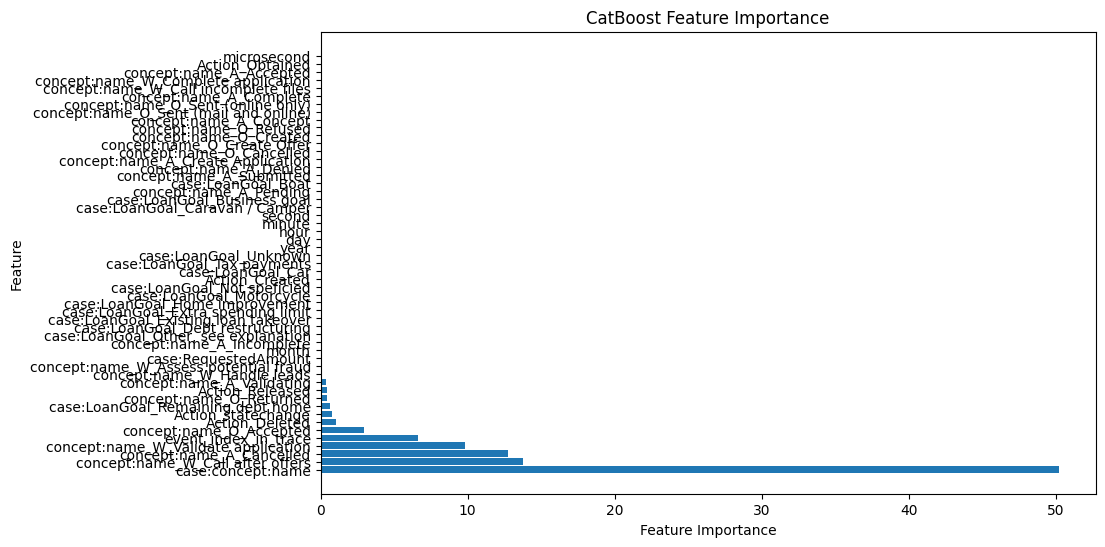

In [22]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained CatBoostRegressor
feature_importance = model.get_feature_importance()

# Get feature names from the original DataFrame (X_train)
feature_names = X_train.columns

# Create a DataFrame to store feature importance values with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.show()

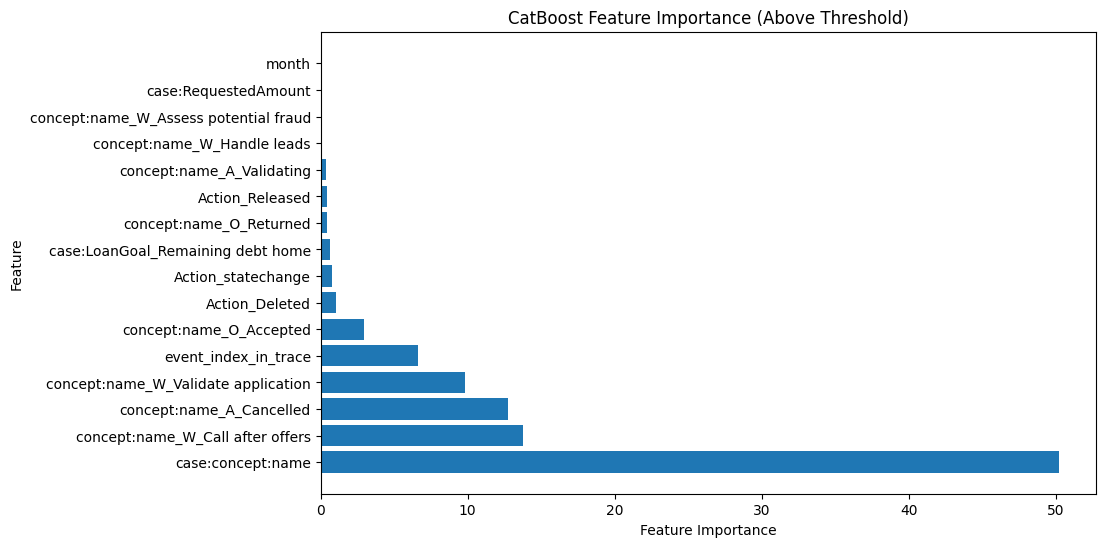

In [24]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained CatBoostRegressor
feature_importance = model.get_feature_importance()

# Get feature names from the original DataFrame (X_train)
feature_names = X_train.columns

# Create a DataFrame to store feature importance values with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Set the threshold for visibility
threshold = 0.01  # Adjust this threshold as needed

# Filter features based on the threshold
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]

# Sort the DataFrame by importance in descending order
important_features = important_features.sort_values(by='Importance', ascending=False)

# Plot feature importance for only the relevant features
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance (Above Threshold)')
plt.show()


In [ ]:
X_train.head()